In [8]:
import occultation_package as occ
from scipy.fft import fft, ifft, fftfreq, fftshift
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.optimize import curve_fit
import math
from scipy.interpolate import make_interp_spline
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.backends.backend_pdf

/Users/jjri6482/miniconda3/envs/sorce_occ/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<Figure size 640x480 with 0 Axes>

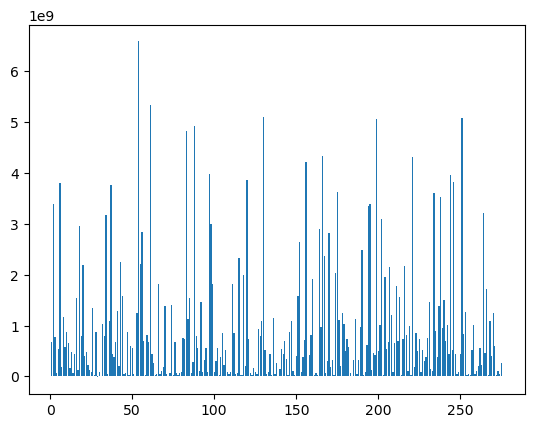

84
32


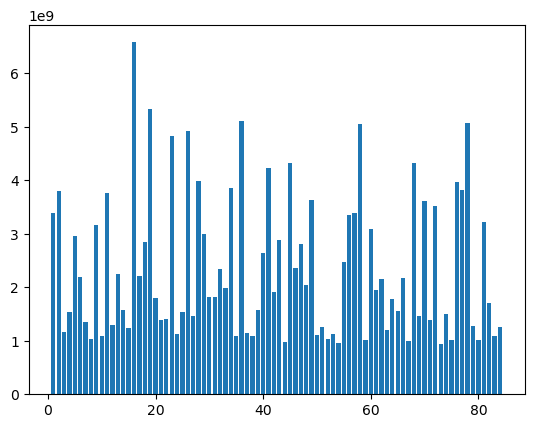

948500609.6934353
6575556243.013998


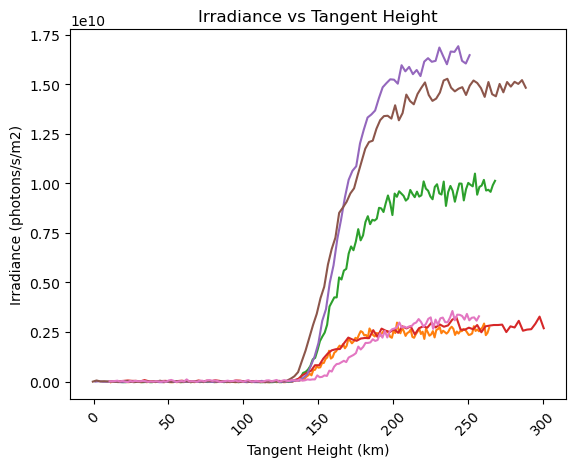

In [22]:
#Holds a list of column density arrays
density_profiles = []
#Holds a list of smoothed density arrays
smoothed_density_profiles = []
#Holds a list of height arrays
height_profiles = []
#A list of file names
file_id = []
#A list of heights
height = []
#A list of column densities
cd = []
#empirically calculated average irradiance for the current data set, hard coded for now
avg_irr = 2393825178.2258515
#Residual values in a list
residuals = []
#Median Irradiance
med_irr = []
#Top half of irradiance files
top_half_irr = []
#Top quarter of irradiance files
top_quarter_irr = []
#Bottom half of irradiance files
bottom_half_irr = []
#Extinction rations
ratio = []
#List of indexes where the extinction ratio is within a specified range
er_range = []

#Makes the multi_files readable
multi_files = open('scans_with_multiple_occultation.txt')
ms = multi_files.readlines()
ms= [i.strip('\n') for i in ms]

#The length of files list in the occultation package
num_occ = len(occ.files)

plt.figure()

#Basic averaging function
def Average(lst):
    return sum(lst) / len(lst)

for i in range(num_occ):
    if occ.files[i].name in ms:
        pass
    else:   
        #Finds only the brightest 8th of the data and data in the specified height range to use.
        #irr = occ.irradiance(occ.files[i])
        #top_half_irr = np.where(irr > (avg_irr + 10000))
        #Runs the get_cd function and stores the height, column density and inverse heights
        density = occ.get_cd(occ.files[i], plot = (i % 4000 == 0))
        cd = density[0]
        smoothed_cd = density[5]
        height = density[1]
        ratio = density[4]
        #Uses the extinction ratio to find the indexes within a specifed range, this will vary for each iteration
        #er_range = np.where((ratio > 0.05) & (ratio < 0.95))
        line_range = np.where((height > 130) & (height < 200))
        #data_range = np.intersect1d(top_half_irr, line_range)
        height = height[line_range]
        cd = cd[line_range]
        smoothed_cd = smoothed_cd[line_range]
        occ.irr_height(occ.files[i], plot = (i % 2000 == 0))
        med_irr.append(np.median(occ.irradiance(occ.files[i])))
        density_profiles.append(cd)
        smoothed_density_profiles.append(smoothed_cd)
        height_profiles.append(height)
        file_id.append(occ.files[i].name)
        

x = np.linspace(1, len(med_irr), num=len(med_irr))
plt.figure()
plt.bar(x, med_irr)
plt.show()

for i in range(len(med_irr)):
    if (med_irr[i] >= Average(med_irr)):
        top_half_irr.append(med_irr[i])
    else:
        bottom_half_irr.append(med_irr[i])    
        
for i in range(len(top_half_irr)):
    if top_half_irr[i] >= Average(top_half_irr):
        top_quarter_irr.append(top_half_irr[i])

print(len(top_half_irr))
print(len(top_quarter_irr))

x_top = np.linspace(1, len(top_half_irr), num=len(top_half_irr))
plt.figure()
plt.bar(x_top, top_half_irr)
plt.show()
print(min(top_half_irr))
print(max(top_half_irr))

'''for i in range(len(med_irr)):
    if occ.files[i].name in ms:
        pass
    elif med_irr[i] in top_half_irr:
        occ.irr_height(occ.files[i], plot = True)'''

for i in range(len(med_irr)):
    if occ.files[i].name in ms:
        pass
    elif med_irr[i] in top_quarter_irr:
        occ.irr_height(occ.files[i], plot = True) 


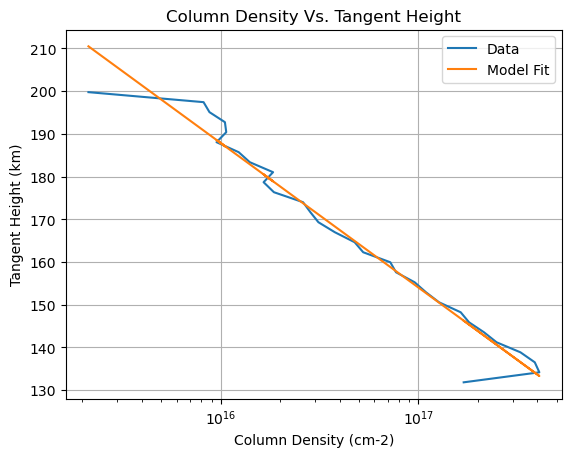

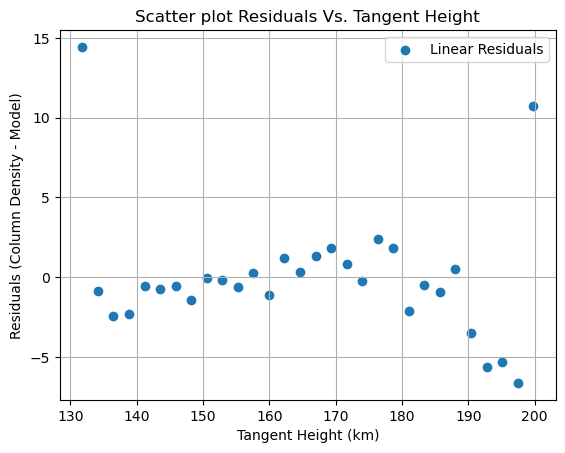

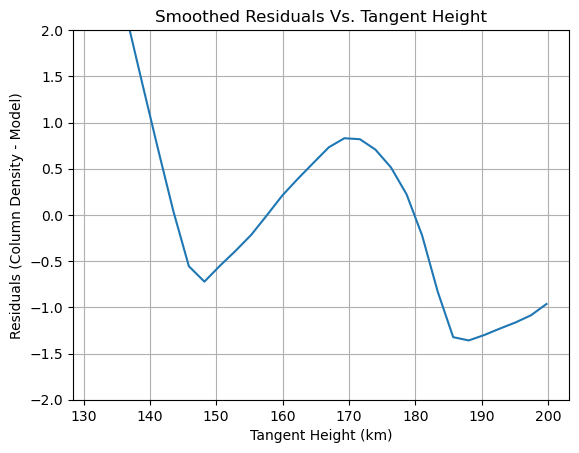

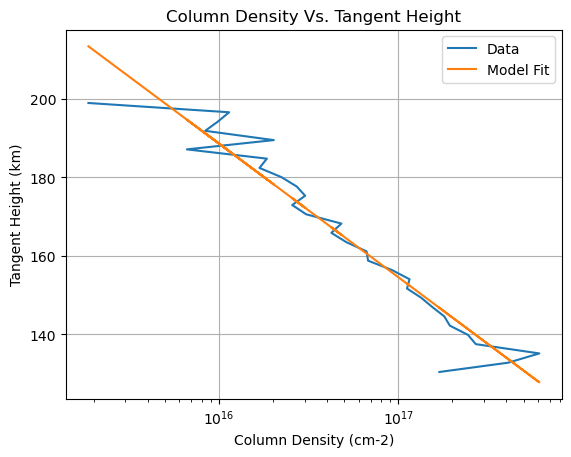

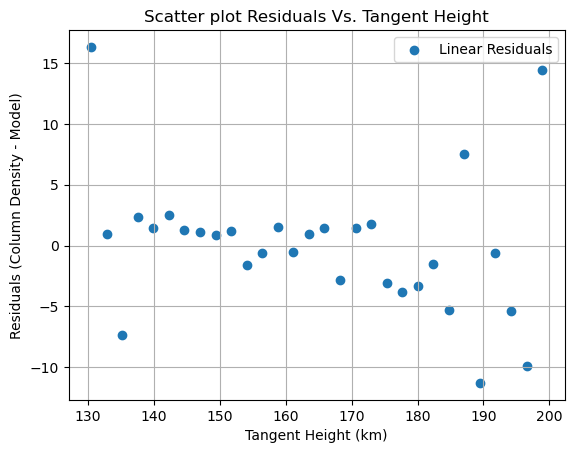

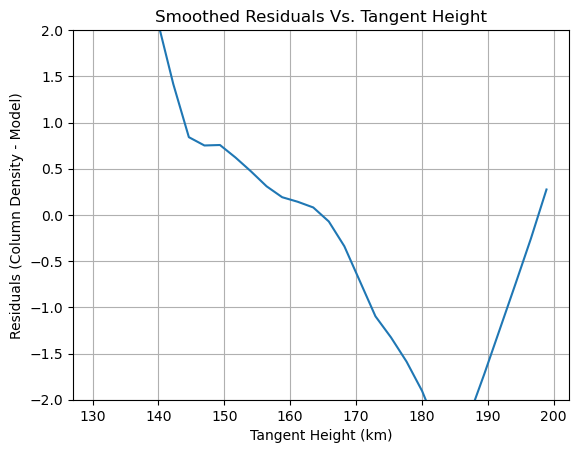

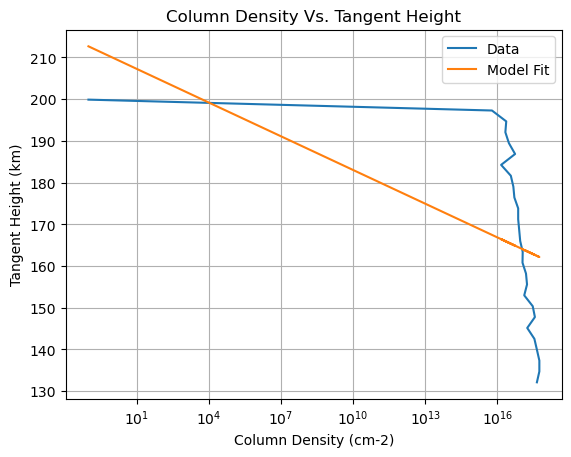

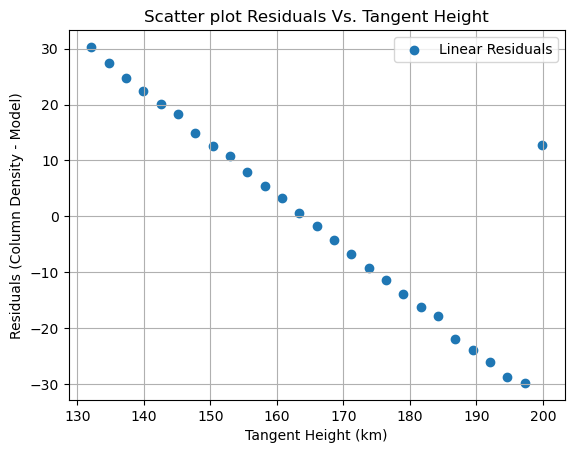

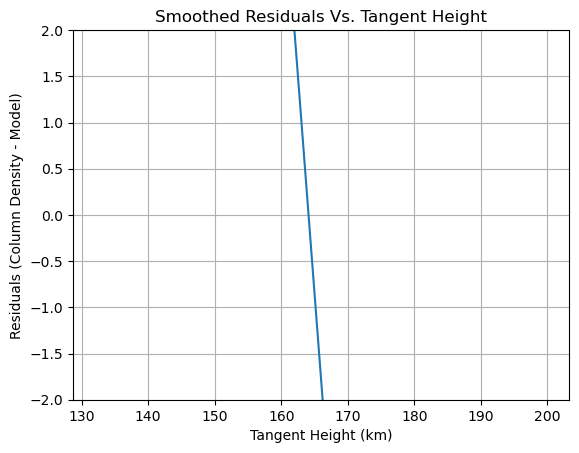

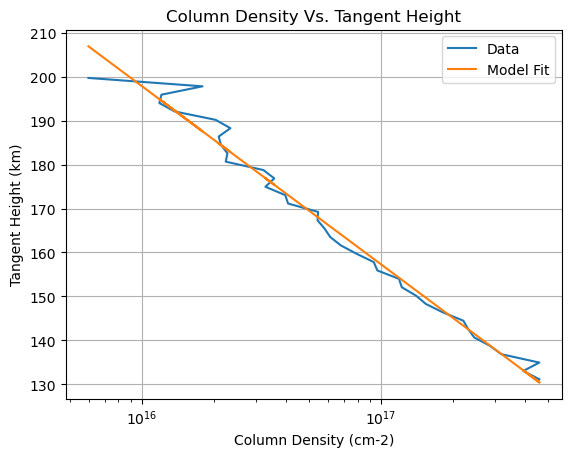

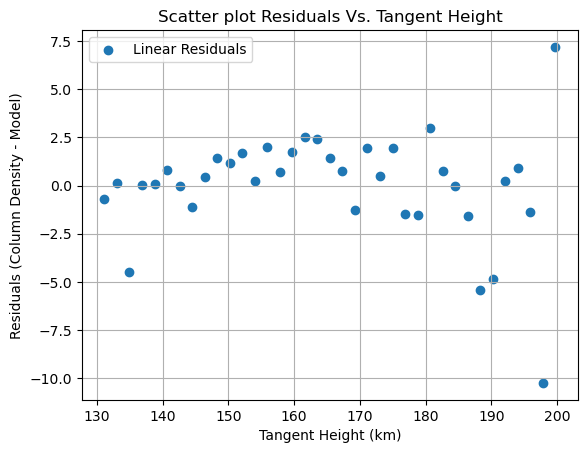

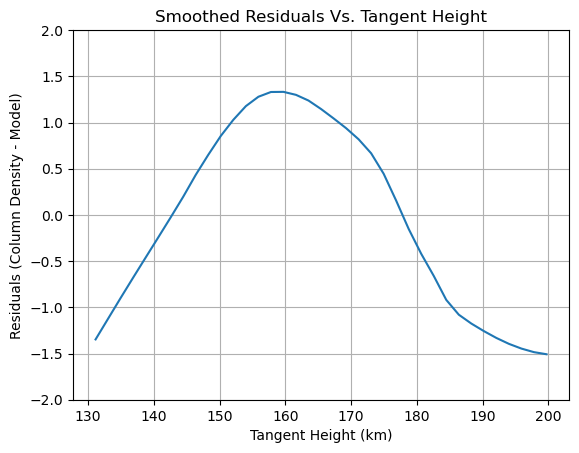

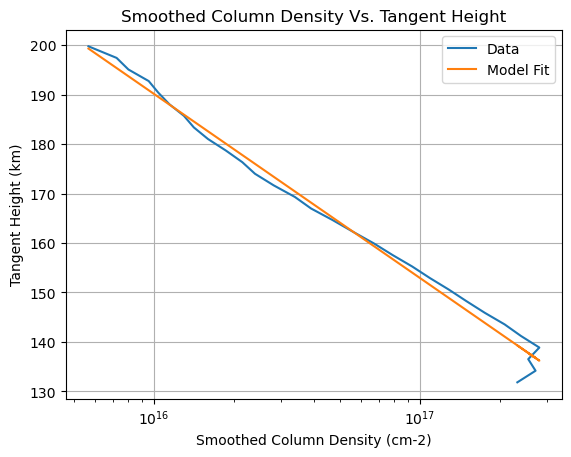

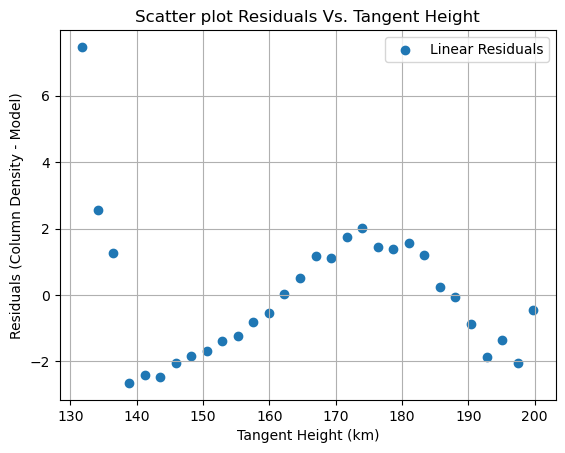

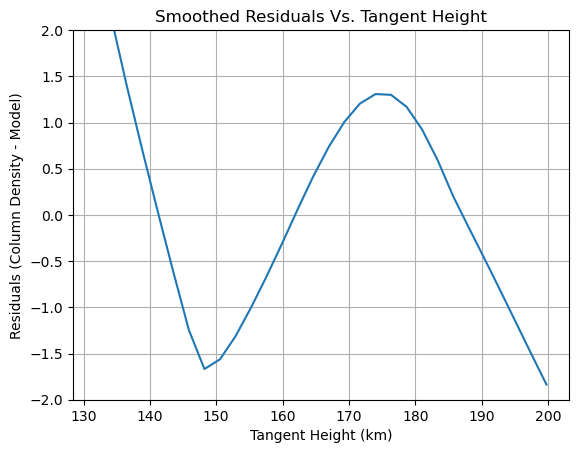

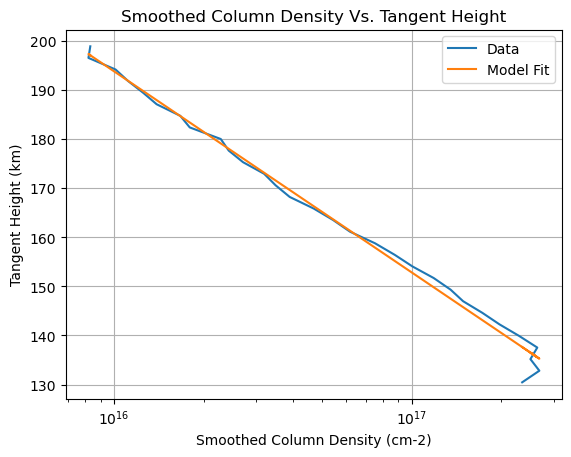

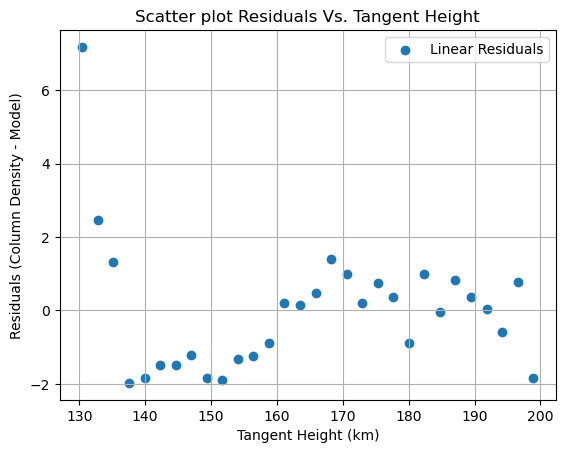

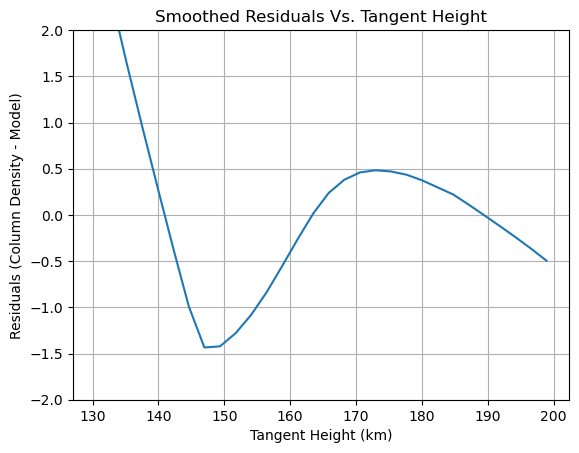

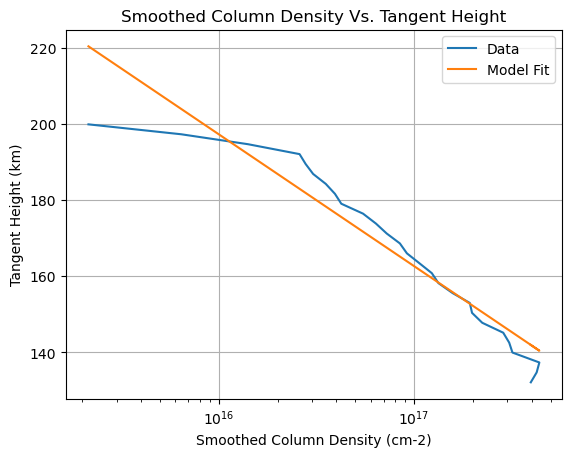

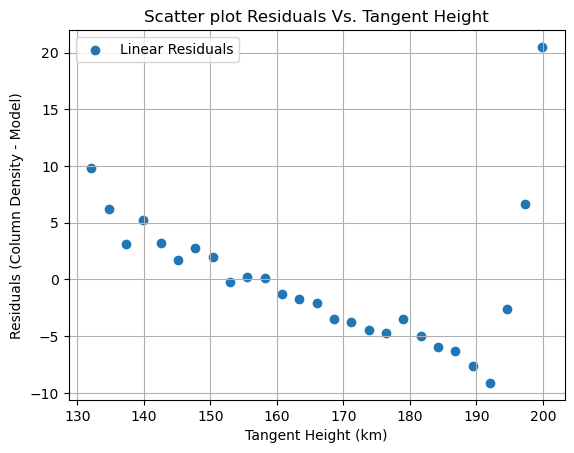

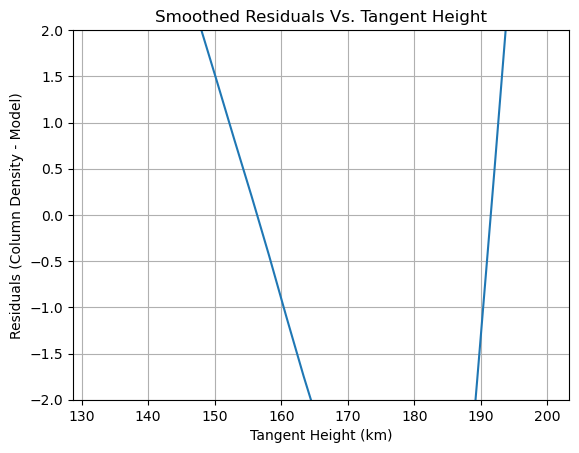

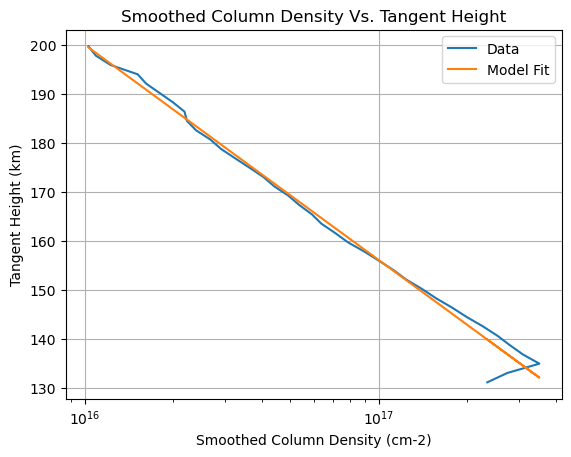

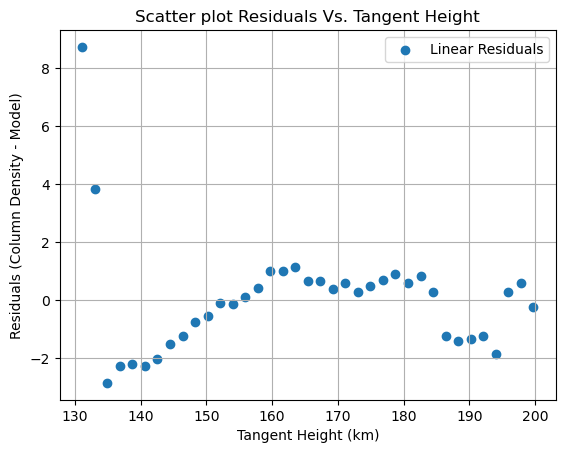

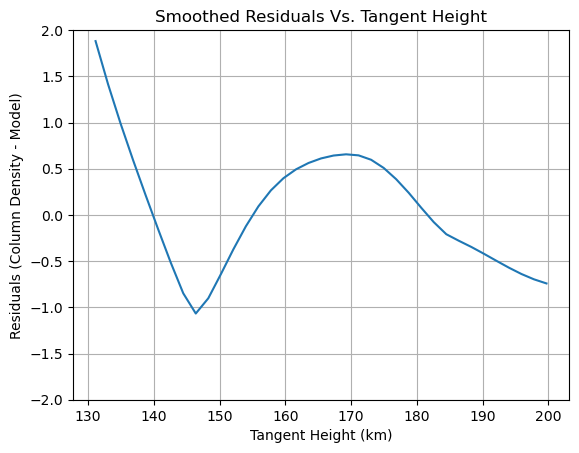

In [25]:
#Linear fit function
def func(x, a, b):
    return a * x + b

#A smoothing function which makes the scatter plots more clear
def smoothing(x, y):
    lowess_frac = 0.5 # size of data (%) for estimation =~ smoothing window
    lowess_it = 0
    x_smooth = x
    y_smooth = lowess(y, x, is_sorted=False, frac=lowess_frac, it=lowess_it, return_sorted=False)
    return x_smooth, y_smooth

with  matplotlib.backends.backend_pdf.PdfPages('Output.pdf') as pdf:
    for i in range(10):
        if occ.files[i].name in ms:
            pass
        elif height_profiles[i].any() == (0.0):
            pass
        else:
            popt, pcov, info, msg, ier = curve_fit(func, np.log(density_profiles[i]), height_profiles[i], full_output = True)
            #Plots the data and the two fitted functions
            plt.figure()
            cdplot = plt.plot(density_profiles[i], height_profiles[i], label = 'Data')
            fitted_curve = plt.plot(density_profiles[i], func(np.log(density_profiles[i]), *popt), label = 'Model Fit')
            #fitted_wave, = plt.plot(cd, wave(np.log(cd), *poptw), label = 'Model Sine Fit', )
            plt.xscale('log')
            plt.xlabel('Column Density (cm-2)')
            plt.ylabel('Tangent Height (km)')
            plt.title('Column Density Vs. Tangent Height')
            plt.legend()
            plt.grid()
            pdf.savefig()
            plt.show()
            plt.close()

            #Calculates residuals, data at a point - fitted function at that point
            residuals = info['fvec']

            #Plots scatter plots of the two residuals
            plt.figure()
            plt.scatter(height_profiles[i], residuals, label = 'Linear Residuals')
            #plt.scatter(height, wave_residuals, label = 'Wave Residuals')
            plt.ylabel('Residuals (Column Density - Model)')
            plt.xlabel('Tangent Height (km)')
            plt.title('Scatter plot Residuals Vs. Tangent Height')
            plt.grid()
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()

            #Plots the smoothed scatter plots, here if the linear smoothed line is oscillatory it directly relates to oscillation but the wave smoothed line closer to zero implies more oscillation
            plt.figure()
            smooth_height, smooth_residuals = smoothing(height_profiles[i], residuals)
            #smooth_height, smooth_wave_residuals = smoothing(height, wave_residuals)
            plt.plot(smooth_height, smooth_residuals, label = 'Linear')
            #plt.plot(smooth_height, smooth_wave_residuals, label = 'Wave')
            plt.ylim(-2, 2)
            plt.ylabel('Residuals (Column Density - Model)')
            plt.xlabel('Tangent Height (km)')
            plt.title('Smoothed Residuals Vs. Tangent Height')
            plt.grid()
            pdf.savefig()
            plt.show()
            plt.close()

    for i in range(10):
        if occ.files[i].name in ms:
            pass
        elif height_profiles[i].any() == (0.0):
            pass
        else:
            popt, pcov, info, msg, ier = curve_fit(func, np.log(smoothed_density_profiles[i]), height_profiles[i], full_output = True)
            #Plots the data and the fitted function
            plt.figure()
            cdplot = plt.plot(smoothed_density_profiles[i], height_profiles[i], label = 'Data')
            fitted_curve = plt.plot(smoothed_density_profiles[i], func(np.log(smoothed_density_profiles[i]), *popt), label = 'Model Fit')
            #fitted_wave, = plt.plot(cd, wave(np.log(cd), *poptw), label = 'Model Sine Fit', )
            plt.xscale('log')
            plt.xlabel('Smoothed Column Density (cm-2)')
            plt.ylabel('Tangent Height (km)')
            plt.title('Smoothed Column Density Vs. Tangent Height')
            plt.legend()
            plt.grid()
            pdf.savefig()
            plt.show()
            plt.close()

            #Calculates residuals, data at a point - fitted function at that point
            residuals = info['fvec']

            #Plots scatter plots of the two residuals
            plt.figure()
            plt.scatter(height_profiles[i], residuals, label = 'Linear Residuals')
            #plt.scatter(height, wave_residuals, label = 'Wave Residuals')
            plt.ylabel('Residuals (Column Density - Model)')
            plt.xlabel('Tangent Height (km)')
            plt.title('Scatter plot Residuals Vs. Tangent Height')
            plt.grid()
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()

            #Plots the smoothed scatter plots, here if the linear smoothed line is oscillatory it directly relates to oscillation but the wave smoothed line closer to zero implies more oscillation
            plt.figure()
            smooth_height, smooth_residuals = smoothing(height_profiles[i], residuals)
            #smooth_height, smooth_wave_residuals = smoothing(height, wave_residuals)
            plt.plot(smooth_height, smooth_residuals, label = 'Linear')
            #plt.plot(smooth_height, smooth_wave_residuals, label = 'Wave')
            plt.ylim(-2, 2)
            plt.ylabel('Residuals (Column Density - Model)')
            plt.xlabel('Tangent Height (km)')
            plt.title('Smoothed Residuals Vs. Tangent Height')
            plt.grid()
            pdf.savefig()
            plt.show()
            plt.close()



<Figure size 640x480 with 0 Axes>